# Demonstrate Unscented Kálmán Filter (UKF)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.simulator import ECMSimulator
from moirae.models.ecm.advancedSOH import ECMASOH
from moirae.models.ecm.ins_outs import ECMInput
from moirae.models.ecm.transient import ECMTransientVector
from moirae.estimators.online import ModelFilterInterface, ControlVariables, OutputMeasurements
from moirae.estimators.online.general.kalman.unscented import UnscentedKalmanFilter as UKF
from moirae.estimators.online.general.kalman import KalmanHiddenState

We will demonstrate the UKF using a single RC Thenevin ECM with static A-SOH. Let's start by instantiating the default 
A-SOH for it.

In [2]:
asoh = ECMASOH.provide_template(has_C0=False, num_RC=1)

We need to prepare a the interface between the ECM model being used and the UKF

In [3]:
class EMC2UKF(ModelFilterInterface):
    asoh = asoh

    def __init__(self) -> None:
        pass

    @property
    def num_hidden_dimensions(self) -> int:
        """ Outputs expected dimensionality of hidden state """
        return 3

    @property
    def num_output_dimensions(self) -> int:
        """ Outputs expected dimensionality of output measurements """
        return 1

    def update_hidden_states(self,
                             hidden_states: np.ndarray,
                             previous_controls: ControlVariables,
                             new_controls: ControlVariables) -> np.ndarray:
        # First, transform the controls into ECM inputs
        previous_input = ECMInput(time=previous_controls.mean[0], current=previous_controls.mean[1])
        new_input = ECMInput(time=new_controls.mean[0], current=new_controls.mean[1])
        
        # Now, iterate through the hidden states to create ECMTransient states and update them
        updated = []
        for hidden_array in hidden_states:
            transient = ECMTransientVector(soc=hidden_array[0], i_rc=np.array([hidden_array[1]]), hyst=hidden_array[2])
            new_transient = ECM.update_transient_state(new_input=new_input,
                                                       transient_state=transient,
                                                       asoh=self.asoh,
                                                       previous_input=previous_input)
            updated.append(new_transient.to_numpy())
        return np.array(updated)
    
    def predict_measurement(self,
                            hidden_states: np.ndarray,
                            controls: ControlVariables) -> np.ndarray:
        # First, transform the controls into ECM inputs
        ecm_input = ECMInput(time=controls.mean[0], current=controls.mean[1])

        # Now, iterate through hidden states to compute terminal voltage
        voltages = []
        for hidden_array in hidden_states:
            transient = ECMTransientVector(soc=hidden_array[0], i_rc=np.array([hidden_array[1]]), hyst=hidden_array[2])
            ecm_out = ECM.calculate_terminal_voltage(new_input=ecm_input,transient_state=transient, asoh=self.asoh)
            voltages.append(ecm_out.to_numpy())
        
        return np.array(voltages)

interface = EMC2UKF()

We will assume the cells starts at 50% SOC. We will establish the following test protocol (sampling rate of ~1 second):
1. Charge the cell to 100% SOC at a C/2 rate for 1 hour.
2. Rest the cell for 10 minutes.
3. Discharge the cell to 0% SOC at a 2C rate for 30 minutes
4. Rest the cell for 10 minutes. 
5. Charge the cell to 50% SOC at 1C rate for 30 minutes. 
6. Rest the cell for 10 minutes. 

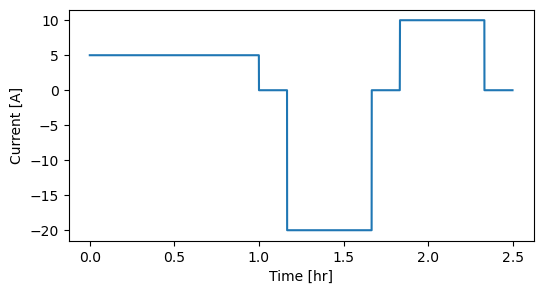

In [4]:
# Get theoretical capacity to determine currents
Qt = asoh.q_t.amp_hour

# Step 1: charge at C/2 for 1 hour to 100% SOC
size = 3600
timestamps = size * np.sort(np.random.random(size=size))
currents = [Qt / 2] * size
# Step 2: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size
# Step 3: discharge at 2C for 30 minutes to 0% SOC
size = 1800
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [-2 * Qt] * size
# Step 4: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size
# Step 5: charge at 1C for 1 hour to 100% SOC
size = 1800
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [Qt] * size

# Step 6: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size

# Checking to make sure we have the currents we want
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(timestamps/3600, currents)
ax.set_xlabel('Time [hr]')
_ = ax.set_ylabel('Current [A]')

Let's now create the initial physical transient state, and initialize the simulator.

In [5]:
# Transient
transient0 = ECMTransientVector.provide_template(has_C0=False, num_RC=1, soc=0.5)

# Simulator
simulator = ECMSimulator(asoh=asoh, transient_state=transient0, keep_history=True)

In order to prepare the UKF, we need to understand the statistics of all relevant variables, which, in this case, are
the SOC, hysteresis voltage, I_RC on the transient state side, and voltage on the measurement side. 

In [6]:
# For the SOC variance, let's assume it is a uniform distribution between 0 and 1. 
# Recall that the variance of the uniform distribution U[a,b] is given by ((b-a)**2)/12
soc_var = 1.0/12
# Similarly, for the hysteresis voltage, we will (wrongly) assume a uniform distribution from -M to M
hyst_max = asoh.h0.get_value(soc=0.5)
hyst_var = (4 * hyst_max * hyst_max) / 12
# For the current in the RC element, we will approximate it as the variance of the total current
irc_var = np.var(currents)

We will maintain the UKF process noise at its default value of 1.0e-08 for all variables, but set the sensor noise to a 
more realistic value corresponding to a voltage error of 1.0e-03 V (1 mV). 

We will also provide an initial state that is a bit off from the real initial state. 

In [7]:
# Calculating sensor noise. 
volt_err = 1.0e-03
sensor_noise = (volt_err / 2) ** 2

# Assembling UKF
initial_state = transient0.to_numpy() + \
    np.random.multivariate_normal(mean=np.zeros(3),
                                  cov=np.diag([soc_var, irc_var, hyst_var])
                                  )
print('Initial state provided to UKF: ', initial_state)

ukf = UKF(model=interface,
          initial_state=KalmanHiddenState(mean=initial_state,
                                          covariance=np.diag([soc_var, irc_var, hyst_var])),
          initial_control=ControlVariables(mean=simulator.previous_input.to_numpy()),
          covariance_sensor_noise=sensor_noise*np.eye(1))

Initial state provided to UKF:  [0.45424374 4.61156301 0.01315102]


Now, let's simulate the ECM and evolve the UKF concurrently. We will draw errors for voltage values from a white noise distribution to mimic a 1 mV error-level.

In [8]:
# Container for UKF predictions
noisy_voltage = []
ukf_predictions = {'transient': [], 'output': []}

for time, current in zip(timestamps, currents):
    # Assemble simulator and UKF inputs
    sim_in = ECMInput(time=time, current=current)
    ukf_control = ControlVariables(mean=np.array([time, current]))
    # Step simulator
    transient, measurement = simulator.step(new_input=sim_in)
    # Prepare measurement for UKF and store noisy voltage
    vt = measurement.terminal_voltage + np.random.normal(scale=(volt_err / 2))
    noisy_voltage += [vt]
    ukf_meas = OutputMeasurements(mean=np.array([vt]))
    ukf_prediction, ukf_transient = ukf.step(u=ukf_control, y=ukf_meas)
    ukf_predictions['transient'].append(ukf_transient)
    ukf_predictions['output'].append(ukf_prediction)

Now, let's plot these results!

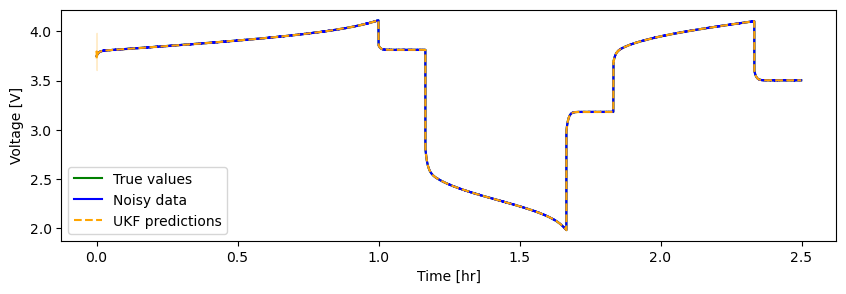

In [9]:
# Converting predictions to arrays for plotting
ukf_vt = np.array([pred.mean.flatten() for pred in ukf_predictions['output']]).flatten()
ukf_vt_err = 2 * np.sqrt([pred.covariance[0,0] for pred in ukf_predictions['output']])
ukf_soc = np.array([pred.mean[0] for pred in ukf_predictions['transient']])
ukf_irc = np.array([pred.mean[1] for pred in ukf_predictions['transient']])
ukf_hyst = np.array([pred.mean[2] for pred in ukf_predictions['transient']])
ukf_soc_err = 2 * np.sqrt([pred.covariance[0,0] for pred in ukf_predictions['transient']])
ukf_irc_err = 2 * np.sqrt([pred.covariance[1,1] for pred in ukf_predictions['transient']])
ukf_hyst_err = 2 * np.sqrt([pred.covariance[1,1] for pred in ukf_predictions['transient']])

# Voltages
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(timestamps / 3600,
        [out.terminal_voltage for out in simulator.measurement_history[1:]],
        color='green',
        label='True values')
ax.plot(timestamps / 3600,
        noisy_voltage,
        color='blue',
        label='Noisy data')
ax.plot(timestamps / 3600,
        ukf_vt,
        color='orange',
        linestyle='--',
        label='UKF predictions')
ax.fill_between(timestamps[1:] / 3600,  # very high initial uncertainty due to bad initialization (delta_SOC = 35%!)
                (ukf_vt + ukf_vt_err)[1:],
                (ukf_vt - ukf_vt_err)[1:],
                color='orange', 
                alpha=0.2)
ax.legend()
ax.set_ylabel('Voltage [V]')
_ = ax.set_xlabel('Time [hr]')

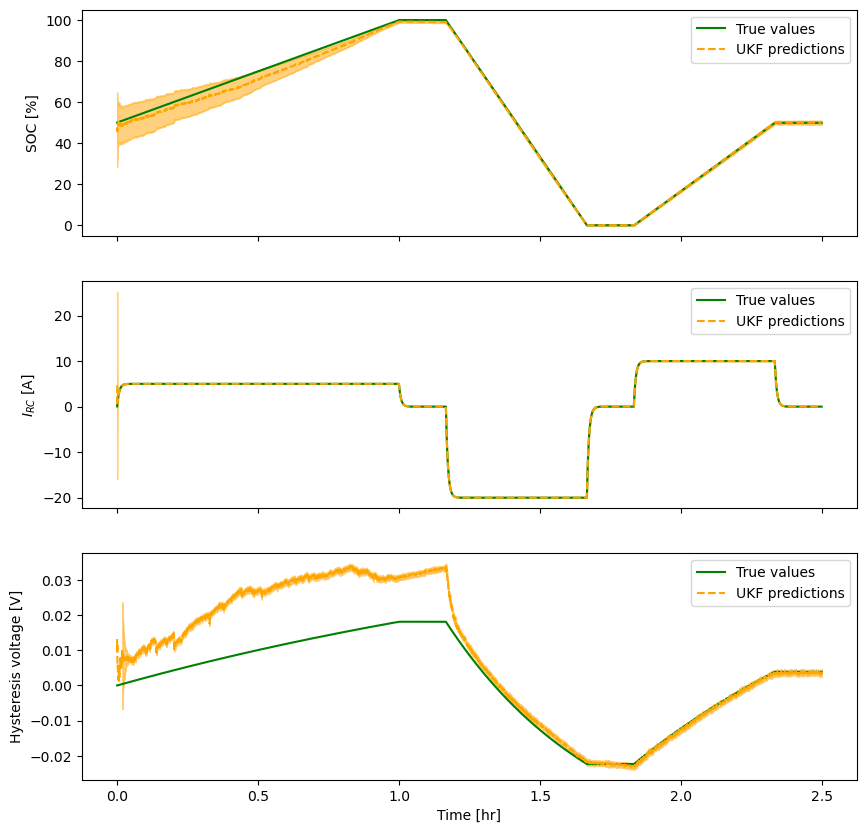

In [10]:
# SOC, I_RC, Hyst
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharex='col')
ax[0].plot(timestamps / 3600,
           100 * np.array([transient.soc for transient in simulator.transient_history[1:]]),
           color='green',
           label='True values')
ax[0].plot(timestamps / 3600,
           100 * ukf_soc,
           linestyle='--',
           color='orange',
           label='UKF predictions')
ax[0].fill_between(timestamps / 3600,
                   100 * (ukf_soc + ukf_soc_err),
                   100 * (ukf_soc - ukf_soc_err),
                   color='orange',
                   alpha=0.5)
ax[1].plot(timestamps / 3600,
           [transient.i_rc[0] for transient in simulator.transient_history[1:]],
           color='green',
           label='True values')
ax[1].plot(timestamps / 3600,
           ukf_irc,
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[1].fill_between(timestamps / 3600,
                   ukf_irc + ukf_irc_err,
                   ukf_irc - ukf_irc_err,
                   color='orange',
                   alpha=0.5)
ax[2].plot(timestamps / 3600,
           [transient.hyst for transient in simulator.transient_history[1:]],
           color='green',
           label='True values')
ax[2].plot(timestamps / 3600,
           ukf_hyst,
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[2].fill_between(timestamps[60:] / 3600,  # for the first 1 minute, uncertainty dominates in hysteresis
                   (ukf_hyst + ukf_hyst_err)[60:],
                   (ukf_hyst - ukf_hyst_err)[60:],
                   color='orange',
                   alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('SOC [%]')
ax[1].set_ylabel(r'$I_{RC}$ [A]')
ax[2].set_ylabel('Hysteresis voltage [V]')
_ = ax[2].set_xlabel('Time [hr]')

The UKf can, however, be used to model any system in which:
1. all relevant quantities can be described by multivariate Gaussian distributions
2. error terms are all white noise (zero-mean Gaussians)

Below, we show how to use the UKF to model a chaotic Lorenz system, in which the hidden variables are positions in a 
cartesian 3D space described by the following dynamics: 
$$
\frac{dx}{dt} = \sigma(y-x) \\
\frac{dy}{dt} = x(\rho - z) - y \\
\frac{dz}{dt} = xy - \beta z
$$
The controls $u$ to this system will be a 5D array containing values of $u=[t,\sigma, \rho, \beta, n]$, in which the main 
Lorenz parameter do not deviate much from $\sigma=10, \rho=28, \beta=8/3$, and $n$ does not affect the dynamics, but the
measurements, given by a 2D vector $M=\left[\left(x^2 + y^2 + z^2\right)^\frac{1}{2}, \left(x^n + y^n + z^n\right)^{\frac{1}{n}}\right]$. 
We will assume small errors in the process with covariances of $\left[\sigma_x = 2, \sigma_y = 3, \sigma_z = 1\right]$ 
and sensor errors of covariances $[\sigma_{M0} = 1, \sigma_{M1}=1]$.

In [11]:
# Define dynamics 
class Lorenz(ModelFilterInterface):
    def __init__(self) -> None:
        pass

    @property
    def num_hidden_dimensions(self) -> int:
        """ Outputs expected dimensionality of hidden state """
        return 3

    @property
    def num_output_dimensions(self) -> int:
        """ Outputs expected dimensionality of output measurements """
        return 2
    
    def update_hidden_states(self,
                             hidden_states: np.ndarray,
                             previous_controls: ControlVariables,
                             new_controls: ControlVariables) -> np.ndarray:
        # Get attractor params
        sigma = new_controls.mean[1]
        rho = new_controls.mean[2]
        beta = new_controls.mean[3]
        dt = new_controls.mean[0] - previous_controls.mean[0]

        # Compute derivatives
        dxdt = sigma * (hidden_states[:,1] - hidden_states[:,0])
        dydt = hidden_states[:,0] * (rho - hidden_states[:,2]) - hidden_states[:,1]
        dzdt = (hidden_states[:,0] * hidden_states[:,1]) - beta * hidden_states[:,2]

        # Build matrix
        update_mat = dt * np.hstack((dxdt.reshape((-1,1)), dydt.reshape((-1,1)), dzdt.reshape((-1,1))))

        return hidden_states + update_mat
    
    def predict_measurement(self,
                            hidden_states: np.ndarray,
                            controls: ControlVariables) -> np.ndarray:
        # Get power parameter
        n = controls.mean[4]

        # Compute outputs
        m0 = ((np.sum(hidden_states ** 2, axis=1)) ** (1./2.)).reshape((-1,1))
        m1 = (abs(np.sum(hidden_states ** n, axis=1)) ** (1./n)).reshape((-1,1))
        return np.hstack((m0, m1))

lorenz = Lorenz()

Now, let us set up the UKF and initial state.

In [12]:
# Approximate initial state
state0 = np.array([0., 0., 0.])
cov_state = np.diag([20, 30, 10])

# Initiate RNG
rng = np.random.default_rng(314159)

# Noise terms
process_noise = 1.0e-02 * np.eye(3)
sensor_noise = np.eye(2)

# Initial control
u0 = ControlVariables(mean=np.array([0., 10, 28, 8./3., 2]))

# Define UKF
initial_state = KalmanHiddenState(mean=state0 + rng.multivariate_normal(mean=np.zeros(3), cov=cov_state),
                                  covariance=cov_state)
print('Initial state provided to UKF: ', initial_state.mean)
ukf_chaos = UKF(model=lorenz,
                initial_state=initial_state,
                initial_control=u0,
                covariance_process_noise=process_noise,
                covariance_sensor_noise=sensor_noise)


Initial state provided to UKF:  [ 4.03575219 -4.02262823 -0.83255373]


Co-simulate attractor and UKF

In [13]:
# Initialize dictionaries to store values
real_values = {'state': [np.array([state0])],
               'measurements': []}
noisy_values = {'state': [np.array([state0 + rng.multivariate_normal(mean=np.zeros(3), cov=process_noise)])],
                'measurements': []}
ukf_values = {'state': [initial_state.model_copy(deep=True)],
              'measurements': []}

# Timestamps
timestamps = [0.0]

# Assign previous control
previous_control = u0

for _ in range(10000):
    # Get a new time
    time = timestamps[-1] + 0.01 * (1. + rng.random())
    timestamps += [time]
    # Choose random new controls
    sigma = 10
    beta = 8./3.
    rho = rng.normal(loc=28, scale=4)
    n = rng.integers(2, 5)
    u = ControlVariables(mean=np.array([time, sigma, rho, beta, n]))

    # Compute new true hidden state
    prev_hidden = noisy_values['state'][-1]
    new_state = lorenz.update_hidden_states(hidden_states=prev_hidden,
                                            previous_controls=previous_control,
                                            new_controls=u)
    real_values['state'] += [new_state.copy()]
    new_state += rng.multivariate_normal(mean=np.zeros(3), cov=process_noise)
    noisy_values['state'] += [new_state.copy()]

    # Get new measurement
    m = lorenz.predict_measurement(hidden_states=new_state, controls=u)
    real_values['measurements'] += [m.copy()]
    m += rng.multivariate_normal(mean=np.zeros(2), cov=sensor_noise)
    noisy_values['measurements'] += [m.copy()]
    
    # Assemble measurement
    measure = OutputMeasurements(mean=m)
    ukf_pred, ukf_hid = ukf_chaos.step(u=u, y=measure)
    ukf_values['state'].append(ukf_hid)
    ukf_values['measurements'].append(ukf_pred)

    # Update previous control
    previous_control = u

Let us plot the results to see how the UKF performs. 

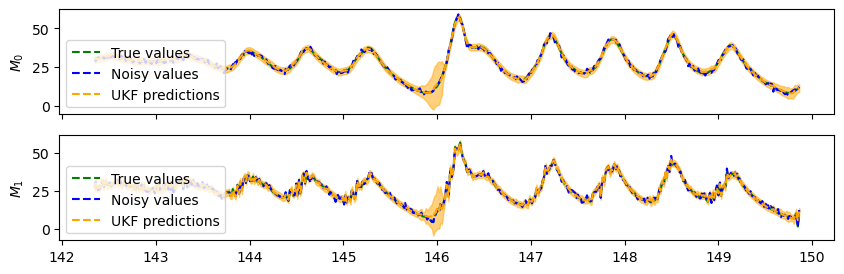

In [14]:
# Getting relevant values
ukf_m0 = np.array([y.mean[0] for y in ukf_values['measurements']])
ukf_m1 = np.array([y.mean[1] for y in ukf_values['measurements']])
ukf_m0_std = np.sqrt(np.array([y.covariance[0,0] for y in ukf_values['measurements']]))
ukf_m1_std = np.sqrt(np.array([y.covariance[1,1] for y in ukf_values['measurements']]))

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10,3), sharex='col')
ax[0].plot(timestamps[-500:],
           [y.flatten()[0]for y in real_values['measurements'][-500:]],
           color='green', 
           linestyle='--',
           label='True values')
ax[0].plot(timestamps[-500:],
           [y.flatten()[0]for y in noisy_values['measurements'][-500:]],
           color='blue',
           linestyle='--',
           label='Noisy values')
ax[0].plot(timestamps[-500:],
           ukf_m0[-500:],
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[0].fill_between(timestamps[-500:], 
                   (ukf_m0 + 2 * ukf_m0_std)[-500:],
                   (ukf_m0 - 2 * ukf_m0_std)[-500:],
                   color='orange',
                   alpha=0.5,
                   zorder=0)

ax[1].plot(timestamps[-500:],
           [y.flatten()[1]for y in real_values['measurements'][-500:]],
           color='green', 
           linestyle='--',
           label='True values')
ax[1].plot(timestamps[-500:],
           [y.flatten()[1]for y in noisy_values['measurements'][-500:]],
           color='blue',
           linestyle='--',
           label='Noisy values')
ax[1].plot(timestamps[-500:],
           ukf_m1[-500:],
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[1].fill_between(timestamps[-500:], 
                   (ukf_m1 + 2 * ukf_m1_std)[-500:],
                   (ukf_m1 - 2 * ukf_m1_std)[-500:],
                   color='orange',
                   alpha=0.5,
                   zorder=1)
ax[0].set_ylabel(r'$M_0$')
ax[1].set_ylabel(r'$M_1$')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

Let's also check that the hidden state predictions are adequate.

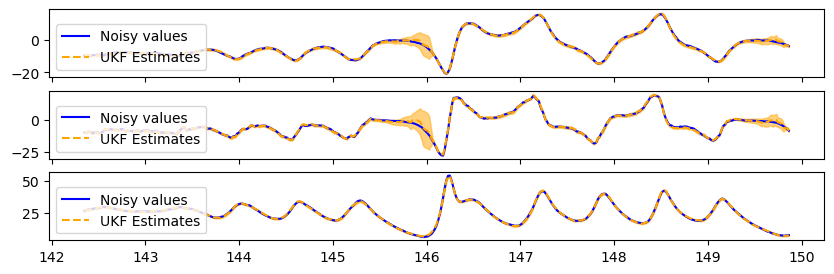

In [15]:
# Getting relevant values
ukf_x = np.array([hid.mean[0] for hid in ukf_values['state']])
ukf_y = np.array([hid.mean[1] for hid in ukf_values['state']])
ukf_z = np.array([hid.mean[2] for hid in ukf_values['state']])
ukf_x_std = np.sqrt(np.array([hid.covariance[0,0] for hid in ukf_values['state']]))
ukf_y_std = np.sqrt(np.array([hid.covariance[1,1] for hid in ukf_values['state']]))
ukf_z_std = np.sqrt(np.array([hid.covariance[2,2] for hid in ukf_values['state']]))
ukf_plot = [[ukf_x, ukf_x_std], [ukf_y, ukf_y_std], [ukf_z, ukf_z_std]]

fig, ax = plt.subplots(3, 1, figsize=(10,3), sharex='col')
for i in range(3):
    ax[i].plot(timestamps[-500:],
               [hid.flatten()[i] for hid in noisy_values['state'][-500:]],
               color='blue',
               label='Noisy values')
    ax[i].plot(timestamps[-500:],
               ukf_plot[i][0][-500:],
               color='orange',
               linestyle='--',
               label='UKF Estimates')
    ax[i].fill_between(timestamps[-500:],
                       (ukf_plot[i][0] + 2 * ukf_plot[i][1])[-500:],
                       (ukf_plot[i][0] - 2 * ukf_plot[i][1])[-500:],
                       color='orange',
                       alpha=0.5)
    ax[i].legend(loc='lower left')


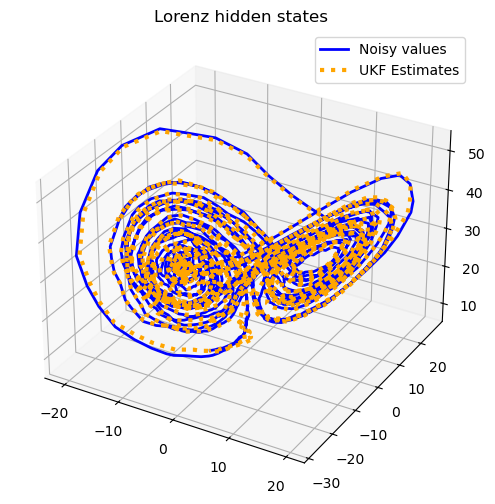

In [16]:
points_to_show = 2000
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot(*np.array([hid.flatten() for hid in noisy_values['state'][-points_to_show:]]).T,
        color='blue',
        linewidth=2,
        # linestyle=':',
        label='Noisy values')
ax.plot(ukf_x[-points_to_show:], ukf_y[-points_to_show:], ukf_z[-points_to_show:], 
        color='orange', 
        linewidth=3,
        linestyle=':',
        label='UKF Estimates')
ax.set_title('Lorenz hidden states')
_ = ax.legend()

Finally, let's double check that our measurement statistics make sense.

In [17]:
# Get the noisy measurements
m0_noise = np.array([y.flatten()[0]for y in noisy_values['measurements']])
m1_noise = np.array([y.flatten()[1]for y in noisy_values['measurements']])

# Check against UKF with error
m0_1sig = np.isclose(m0_noise, ukf_m0, atol=1 * ukf_m0_std)
m0_2sig = np.isclose(m0_noise, ukf_m0, atol=2 * ukf_m0_std)
m0_3sig = np.isclose(m0_noise, ukf_m0, atol=3 * ukf_m0_std)
m1_1sig = np.isclose(m1_noise, ukf_m1, atol=1 * ukf_m1_std)
m1_2sig = np.isclose(m1_noise, ukf_m1, atol=2 * ukf_m1_std)
m1_3sig = np.isclose(m1_noise, ukf_m1, atol=3 * ukf_m1_std)

# Only consider the last few points, when the UKF should have converged
last_points = 500
m0_1sig_frac = np.sum(m0_1sig[-last_points:])/last_points
m0_2sig_frac = np.sum(m0_2sig[-last_points:])/last_points
m0_3sig_frac = np.sum(m0_3sig[-last_points:])/last_points
m1_1sig_frac = np.sum(m1_1sig[-last_points:])/last_points
m1_2sig_frac = np.sum(m1_2sig[-last_points:])/last_points
m1_3sig_frac = np.sum(m1_3sig[-last_points:])/last_points

# Check stats, but be slightly more lenient than a true Gaussian
assert m0_1sig_frac >= 0.65, 'Fraction within 1 standard deviation is %2.1f %% < 65%%!!' % (100 * m0_1sig_frac)
assert m0_2sig_frac >= 0.925, 'Fraction within 2 standard deviations is %2.1f %% < 92.5%%!!' % (100 * m0_2sig_frac)
assert m0_3sig_frac >= 0.99, 'Fraction within 3 standard deviations is %2.1f %% < 99%%!!' % (100 * m0_3sig_frac)
assert m1_1sig_frac >= 0.65, 'Fraction within 1 standard deviation is %2.1f %% < 65%%!!' % (100 * m1_1sig_frac)
assert m1_2sig_frac >= 0.925, 'Fraction within 2 standard deviations is %2.1f < 92.5%%!!' % (100 * m1_2sig_frac)
assert m1_3sig_frac >= 0.99, 'Fraction within 3 standard deviations is %2.1f %% < 99%%!!' % (100 * m1_3sig_frac)

Finally, let's do the same for the hidden state statistic, but be a bit more lenient

In [18]:
# Getting noisy hidden states
x_noise = np.array([hid.flatten()[0]for hid in noisy_values['state']])
y_noise = np.array([hid.flatten()[1]for hid in noisy_values['state']])
z_noise = np.array([hid.flatten()[2]for hid in noisy_values['state']])

# Check against error
x_1sig = np.isclose(x_noise, ukf_x, atol=1 * ukf_x_std)
x_2sig = np.isclose(x_noise, ukf_x, atol=2 * ukf_x_std)
x_3sig = np.isclose(x_noise, ukf_x, atol=3 * ukf_x_std)
y_1sig = np.isclose(y_noise, ukf_y, atol=1 * ukf_y_std)
y_2sig = np.isclose(y_noise, ukf_y, atol=2 * ukf_y_std)
y_3sig = np.isclose(y_noise, ukf_y, atol=3 * ukf_y_std)
z_1sig = np.isclose(z_noise, ukf_z, atol=1 * ukf_z_std)
z_2sig = np.isclose(z_noise, ukf_z, atol=2 * ukf_z_std)
z_3sig = np.isclose(z_noise, ukf_z, atol=3 * ukf_z_std)

# Only consider the last few points again
x_1sig_frac = np.sum(x_1sig[-last_points:])/last_points
x_2sig_frac = np.sum(x_2sig[-last_points:])/last_points
x_3sig_frac = np.sum(x_3sig[-last_points:])/last_points
y_1sig_frac = np.sum(y_1sig[-last_points:])/last_points
y_2sig_frac = np.sum(y_2sig[-last_points:])/last_points
y_3sig_frac = np.sum(y_3sig[-last_points:])/last_points
z_1sig_frac = np.sum(z_1sig[-last_points:])/last_points
z_2sig_frac = np.sum(z_2sig[-last_points:])/last_points
z_3sig_frac = np.sum(z_3sig[-last_points:])/last_points

# Check stats, but give a wider margin than a true Gaussian, as this is a very chaotic system and we are looking at the
# hidden states, instead of number the UKF can measure itself against. 
assert x_1sig_frac > 0.62,  'Fraction within 1 standard deviation is %2.1f %% < 62%%!!' % (100 * x_1sig_frac)
assert x_2sig_frac > 0.90,  'Fraction within 1 standard deviation is %2.1f %% < 90%%!!' % (100 * x_2sig_frac)
assert x_3sig_frac > 0.95,  'Fraction within 1 standard deviation is %2.1f %% < 95%%!!' % (100 * x_3sig_frac)
assert y_1sig_frac > 0.62,  'Fraction within 1 standard deviation is %2.1f %% < 62%%!!' % (100 * y_1sig_frac)
assert y_2sig_frac > 0.90,  'Fraction within 1 standard deviation is %2.1f %% < 90%%!!' % (100 * y_2sig_frac)
assert y_3sig_frac > 0.95,  'Fraction within 1 standard deviation is %2.1f %% < 95%%!!' % (100 * y_3sig_frac)
assert z_1sig_frac > 0.62,  'Fraction within 1 standard deviation is %2.1f %% < 62%%!!' % (100 * z_1sig_frac)
assert z_2sig_frac > 0.90,  'Fraction within 1 standard deviation is %2.1f %% < 90%%!!' % (100 * z_2sig_frac)
assert z_3sig_frac > 0.95,  'Fraction within 1 standard deviation is %2.1f %% < 95%%!!' % (100 * z_3sig_frac)